# 【Face Alignment其二】face alignment的3D投影算法

本文参考代码为：https://github.com/dougsouza/face-frontalization ,和博文：https://talhassner.github.io/home/publication/2014_MVAP

在[《【Face Alignment其一】用dlib进行face alignment的简单实现》](https://github.com/konatasick/machine_learning_note/blob/master/face%20alignment1.ipynb)中，讲解了Face Alignment的简单实现。但通常这种程度的alignment是不够的。目前一个主流的做法是利用人脸landmark的3D模型，将facial landmark投影至3D空间后再投影到正面上。

在源代码的readme.MD中，展示了一个例子：

![a](https://raw.githubusercontent.com/dougsouza/face-frontalization/master/example.png)

在这个源代码对应的论文中，在基础的face alignment之后增加了一个soft symmetry的步骤，用于填补脸部的缺失部分，此处算法在此暂时忽略不计。本文主要分析由query image转变为frontalized without symmetry的算法。具体论文见：[Viewing Real-World Faces in 3D](https://talhassner.github.io/home/projects/ViewFaces3D/HassnerICCV2013.pdf)和[Effective Face Frontalization in Unconstrained Images](https://talhassner.github.io/home/projects/frontalize/CVPR2015_frontalize.pdf)



## 3D投影

![a](figure/face_alignment2-1.png)

令(b)中任意一点为$p_i=(x_i,y_i)^T$，其对应的点在(c)中为$p_i^\prime=(x_i^\prime,y_i^\prime)^T$，在3D模型的(d)中为$P_i=(X_i,Y_i,Z_i)^T$。

在3D模型确认后，我们选择合适的旋转角度将其投影为一个正面的视角，用于作为参照的frontalized coordinate system，即(c)，其投影公式为：

$$p^\prime\sim C_M P$$

对于一张输入的图片，我们在得到其landmark后，计算和3D模型的投影矩阵，即：

$$p\sim C_Q P$$

对于一张输入的图片，将其转化为frontalized face的公式即为：

$$p^\prime\sim C_M C_Q^{-1} p$$



## Face frontalization
在代码中，我们首先得到输入图片的landmark

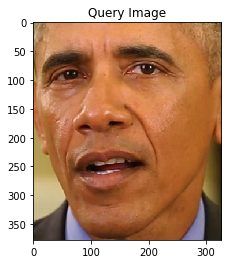

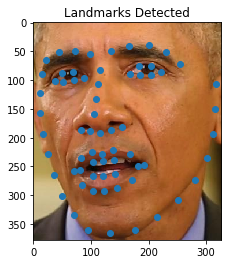

In [1]:
%matplotlib inline
import frontalize
import facial_feature_detector as feature_detection
import camera_calibration as calib
import scipy.io as io
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils


# load query image
img = cv2.imread("1.jpg", 1)
org_lmarks = feature_detection.get_landmarks(img)
img=img[int(org_lmarks[0][19,1])-50:int(org_lmarks[0][8,1])+10, int(org_lmarks[0][0,0])-10:int(org_lmarks[0][16,0])+10]
plt.title('Query Image')
plt.imshow(img[:, :, ::-1])

# extract landmarks from the query image
# list containing a 2D array with points (x, y) for each face detected in the query image
lmarks = feature_detection.get_landmarks(img)
plt.figure()
plt.title('Landmarks Detected')
plt.imshow(img[:, :, ::-1])
plt.scatter(lmarks[0][:, 0], lmarks[0][:, 1])


首先载入现有的3Dmodel

In [2]:
# load detections performed by dlib library on 3D model and Reference Image
model3D = frontalize.ThreeD_Model("model3Ddlib.mat", 'model_dlib')
print model3D.out_A
print model3D.size_U
print model3D.model_TD.shape
print model3D.ref_U.shape

[[492.3077 0.0000 160.0000]
 [0.0000 492.3077 160.0000]
 [0.0000 0.0000 1.0000]]
[320 320]
(68, 3)
(320, 320, 3)


之后计算其3D投影。

In [3]:
# perform camera calibration according to the first face detected
proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])
print proj_matrix #C_Q

[[474.3332 205.5957 26.5582 46052.6523]
 [-23.8351 238.7583 -458.6864 61580.3750]
 [-0.0973 0.9812 0.1669 290.0462]]


这个投影矩阵将3D坐标投影至2D坐标，即为$p\sim C_Q P$中的$C_Q$。

接下来计算3D坐标，使用refU map实现2D到3D的转换：

In [4]:
threedee = np.reshape(model3D.ref_U , (-1, 3), order='F').transpose()
print threedee.shape
#C_Q * P
temp_P=np.vstack((threedee, np.ones((1, threedee.shape[1]))))
print temp_P.shape

(3, 102400)
(4, 102400)


这里要注意一点的是，remap中map的计算是通过转换矩阵的逆求得的。故由

$$p^\prime\sim C_M C_Q^{-1} p$$

可得

$$newmap=C_Q C_M^{-1}*oldmap$$

若要计算map，我们需要得到$C_Q C_M^{-1}$，而$C_M^{-1}*oldmap$就是上面的threedee

In [5]:
temp_proj = proj_matrix * temp_P

之后计算对应的map

In [6]:


temp_proj2 = np.divide(temp_proj[0:2, :], np.tile(temp_proj[2, :], (2,1)))
temp_proj2 -= 1

#remap
mapX = temp_proj2[0,:].astype(np.float32)
mapY = temp_proj2[1,:].astype(np.float32)

mapX = np.reshape(mapX,(-1,320), order = 'F')
mapY = np.reshape(mapY,(-1,320), order = 'F')

最后，根据计算出来的map进行remap生成frontalized face

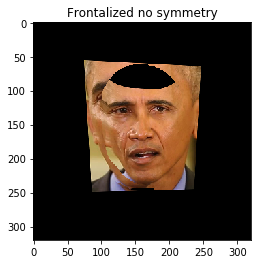

In [7]:
frontal_raw = cv2.remap(img, mapX, mapY, cv2.INTER_CUBIC)

frontal_raw = frontal_raw.reshape((-1,3), order = 'F')
frontal_raw = frontal_raw.reshape((320, 320, 3), order = 'F')

frontal_raw[frontal_raw > 255] = 255
frontal_raw[frontal_raw < 0] = 0
frontal_raw = frontal_raw.astype('uint8')

plt.figure()
plt.title('Frontalized no symmetry')
plt.imshow(frontal_raw[:, :, ::-1])

# 附录：remap用法

关于cv2.remap这个函数，需要展开讲一下。该函数的结构是：







In [ ]:
void cv::remap	(	InputArray 	src,
                    OutputArray 	dst,
                    InputArray 	map1,
                    InputArray 	map2,
                    int 	interpolation,
                    int 	borderMode = BORDER_CONSTANT,
                    const Scalar & 	borderValue = Scalar() 
                    )	

第一个参数是输入的图片，第二个参数是输出的图片，第三个和第四个分别是x和y的map，第五个是插值方式，有4种：

（1）INTER_NEAREST——最近邻插值

（2）INTER_LINEAR——双线性插值（默认）

（3）INTER_CUBIC——双三样条插值（默认）

（4）INTER_LANCZOS4——lanczos插值（默认）

第六个和第七个按照默认值就好。关键在于如何得到map1和map2。

remap做的工作可以用下述公式表示：

$$dst(x,y)=src(map_x(x,y),map_y(x,y))$$

举一个简单的例子，若给定一个10* 10的图片

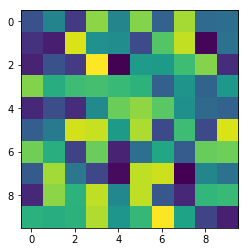

In [8]:
img=np.random.rand(10,10)
plt.imshow(img)

接下来我们要使用remap矩阵对这张图片进行缩小，若表示为矩阵运算，即为：

$$p^\prime =M*p$$


令s=0.5，有：

In [9]:
M=np.mat([[0.5, 0 ,0],
  [0, 0.5, 0],
  [0 ,0, 1]])
print M

[[0.5000 0.0000 0.0000]
 [0.0000 0.5000 0.0000]
 [0.0000 0.0000 1.0000]]


而缩小一倍以后，点（10，10）在新图片的位置应为（5，5）。
将这个变化体现在map上，即为

$$map_x(5,5)=10$$
$$map_y(5,5)=10$$

进一步我们可以得到

$$map_x(x,y)=x/s$$
$$map_y(x,y)=y/s$$

所以新的map_x和map_y应为：



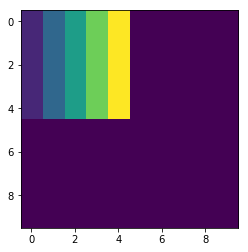

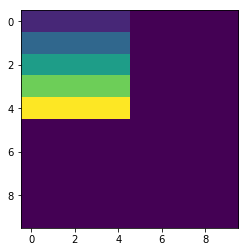

In [11]:
map0=np.mat([[2, 4, 6, 8, 10],
             [2, 4, 6, 8, 10],
             [2, 4, 6, 8, 10],
             [2, 4, 6, 8, 10],
             [2, 4, 6, 8, 10]])
map0-=1
map1=np.zeros((10,10))
map1[0:5,0:5]=map0

map2=map1.T

map1=map1.astype(np.float32)
map2=map2.astype(np.float32)
plt.imshow(map1)
plt.figure()
plt.imshow(map2)

而新图片即为：

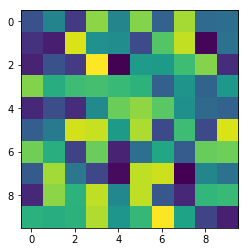

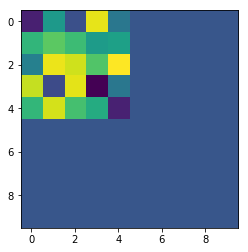

In [12]:
new_img= cv2.remap(img, map1, map2, cv2.INTER_LINEAR)
plt.imshow(img)
plt.figure()
plt.imshow(new_img)

通过观察可知，remap是通过转换矩阵的逆乘以原坐标网点得到的。


若我们要建立一个新的map，则我们对于原图每一个坐标设立一个点，并把每一个对应的（x，y）变成（x/s,y/s）。

完整的remap流程如下：

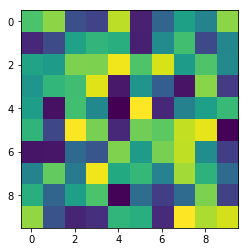

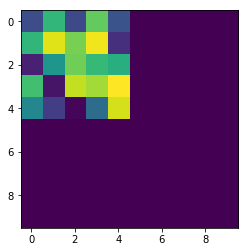

In [24]:
img=np.random.rand(10,10)
plt.imshow(img)

# built original map
map0=[]
for i in range(10):
    map0.append(range(10))
map0=np.array(map0)
map1=map0+1
map2=map1.T

map1=np.reshape(map1, (1, -1))
map2=np.reshape(map2, (1, -1))
temp_p=np.vstack((map1,map2,np.ones((1, map1.shape[1]))))

# scale matrix
M=np.mat([[0.5, 0 ,0],
  [0, 0.5, 0],
  [0 ,0, 1]])

new_P=M.I* temp_p
temp_proj2 = np.divide(new_P[0:2, :], np.tile(new_P[2, :], (2,1)))

temp_proj2 -= 1

mapX = temp_proj2[0,:].astype(np.float32)
mapY = temp_proj2[1,:].astype(np.float32)

mapX = np.reshape(mapX,(-1,10), order = 'F')
mapY = np.reshape(mapY,(-1,10), order = 'F')

new_img= cv2.remap(img, mapX, mapY, cv2.INTER_LINEAR)
plt.figure()
plt.imshow(new_img)